In [18]:
import os
import shutil
import nibabel as nib
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from invert import invert_ebb, coregister, compute_gain_matrix
from simulate import run_dipole_simulation
from laminar import sliding_window_model_comparison
from util import matlab_context

In [19]:
# Where to put simulated data
tmp_dir='/scratch/bonaiuto/simulated_data/sliding_window'

# Subject information for data to base simulations on
subj_id='sub-104'
ses_id='ses-01'
# Fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# Native space MRI to use for coregistration
mri_fname = os.path.join('./test_data','spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')
# Mesh to use for forward model
multilayer_mesh_fname = os.path.join('./test_output', subj_id, 'multilayer.11.ds.link_vector.gii')

# Get name of each mesh that makes up the layers of the multilayer mesh
n_layers=11
layers = np.linspace(1, 0, n_layers)
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join('./test_output', subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join('./test_output', subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join('./test_output', subj_id, 'white.ds.link_vector.gii'))
    
# Load multilayer mesh and compute the number of vertices per layer
mesh=nib.load(multilayer_mesh_fname)
verts_per_surf=int(mesh.darrays[0].data.shape[0]/n_layers)

# Data file to base simulations on
data_file=os.path.join('./test_data', 'processed', subj_id, ses_id, 'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(os.path.join(data_path, f'{data_base}.mat'), os.path.join(tmp_dir, f'{data_base}.mat'))
shutil.copy(os.path.join(data_path, f'{data_base}.dat'), os.path.join(tmp_dir, f'{data_base}.dat'))

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

# Precompute gain matrices to speed up simulations
surf_base=os.path.splitext(os.path.split(multilayer_mesh_fname)[-1])[0]
gainmat=os.path.join(data_path, f'SPMgainmatrix_{data_base}_{surf_base}.mat')
layer_gainmats=[]
with matlab_context() as eng:
    if not os.path.exists(gainmat):                
        coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname, mat_eng=eng)        
        compute_gain_matrix(base_fname, gainmat, mat_eng=eng)        
    for layer_fname in layer_fnames:
        surf_base=os.path.splitext(os.path.split(layer_fname)[-1])[0]
        layer_gainmat=os.path.join(data_path, f'SPMgainmatrix_{data_base}_{surf_base}.mat')
        if not os.path.exists(layer_gainmat):        
            coregister(nas, lpa, rpa, mri_fname, layer_fname, base_fname, mat_eng=eng)        
            compute_gain_matrix(base_fname, layer_gainmat, mat_eng=eng)
        layer_gainmats.append(layer_gainmat)

In [20]:
# Invert the subject's data. This step only has to be done once - this is just to compute the forward model
# that will be used in the simulations

# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size=5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

with matlab_context() as eng:
    # Coregister data to multilayer mesh
    coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname, mat_eng=eng)

    # Run inversion
    [_,_]=invert_ebb(multilayer_mesh_fname, base_fname, n_layers, patch_size=patch_size, 
                     n_temp_modes=n_temp_modes, gain_mat_fname=gainmat, mat_eng=eng)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


Text(0, 0.5, 'Amplitude (nAm)')

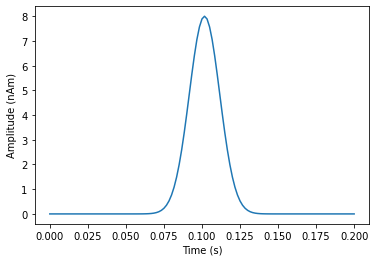

In [23]:
# Vertex to simulate activity at
sim_vertex=1520
# Strength of simulated activity (nAm)
dipole_moment=8
# Size of simulated patch of activity (mm)
sim_patch_size=5
# SNR of simulated data (dB)
SNR=-20
# Temporal width of the simulated Gaussian
signal_width=.01 # 10ms

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2))
plt.plot(time,dipole_moment*sim_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [24]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 1
# Size of sliding window (in time steps)
win_size=10
# Whether or not windows overlap
win_overlap=True

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


Text(0, 0.5, '$\\Delta$F')

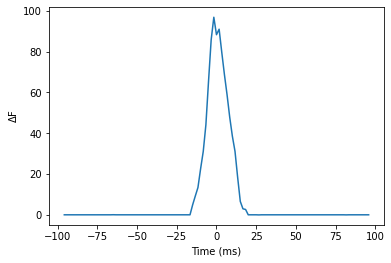

In [25]:
# Simulate at a vertex on the pial surface
pial_vertex=sim_vertex
# Orientation of the simulated dipole
pial_unit_norm=mesh.darrays[2].data[pial_vertex,:]
prefix=f'sim_{sim_vertex}_pial.'

with matlab_context() as eng:
    # Generate simulated data
    pial_sim_fname=run_dipole_simulation(base_fname, prefix, pial_vertex, sim_signal, pial_unit_norm, 
                                         dipole_moment, sim_patch_size, SNR, average_trials=False, mat_eng=eng) 

    # Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
    [Fs,wois]=sliding_window_model_comparison(sim_vertex, nas, lpa, rpa, mri_fname, 
                                              [layer_fnames[0], layer_fnames[-1]], pial_sim_fname, 
                                              patch_size=patch_size, n_temp_modes=sliding_n_temp_modes,
                                              win_size=win_size, win_overlap=win_overlap, 
                                              gain_mat_fnames=[layer_gainmats[0], layer_gainmats[-1]], mat_eng=eng)

# Plot difference in free energy over time (pial minus white) - this should be negative at the beginning and end 
# of the burst, and positive at the center
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


Text(0, 0.5, '$\\Delta$F')

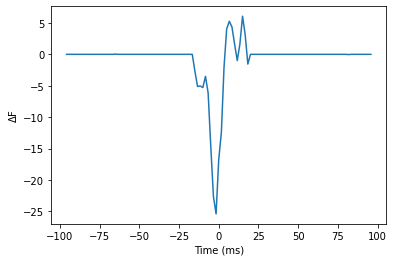

In [26]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex=(n_layers-1)*verts_per_surf+sim_vertex
# Orientation of the simulated dipole
white_unit_norm=-1*mesh.darrays[2].data[white_vertex,:]
prefix=f'sim_{sim_vertex}_white.'

with matlab_context() as eng:
    # Generate simulated data
    white_sim_fname=run_dipole_simulation(base_fname, prefix, white_vertex, sim_signal, white_unit_norm, 
                                          dipole_moment, sim_patch_size, SNR, average_trials=False, mat_eng=eng) 

    # Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
    [Fs,wois]=sliding_window_model_comparison(sim_vertex, nas, lpa, rpa, mri_fname, 
                                              [layer_fnames[0], layer_fnames[-1]], white_sim_fname, 
                                              patch_size=patch_size, n_temp_modes=sliding_n_temp_modes,
                                              win_size=win_size, win_overlap=win_overlap, 
                                              gain_mat_fnames=[layer_gainmats[0], layer_gainmats[-1]], mat_eng=eng)

# Plot difference in free energy over time (pial minus white) - this should be negative at the beginning and end 
# of the burst, and positive at the center
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

In [27]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run sliding window model 
# comparison across all layers
all_layerF=[]
with matlab_context() as eng:
    for l in range(len(layers)):
        print(f'Simulating in layer {l}')
        l_vertex=l*verts_per_surf+sim_vertex
        l_norm=mesh.darrays[2].data[l_vertex,:]
        if l>5:
            l_norm=-1*l_norm

        prefix=f'sim_{sim_vertex}{l}.'
        l_sim_fname=run_dipole_simulation(base_fname, prefix, l_vertex, sim_signal, l_norm, dipole_moment, 
                                          sim_patch_size, SNR, average_trials=False, mat_eng=eng) 

        [Fs,wois]=sliding_window_model_comparison(sim_vertex, nas, lpa, rpa, mri_fname, layer_fnames,
                                                  l_sim_fname, patch_size=patch_size, 
                                                  n_temp_modes=sliding_n_temp_modes, win_size=win_size, 
                                                  win_overlap=win_overlap, 
                                                  gain_mat_fnames=layer_gainmats, mat_eng=eng)
        

        all_layerF.append(Fs)
all_layerF=np.squeeze(np.array(all_layerF))

Simulating in layer 0
Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ./test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ./test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ./test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ./test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ./test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ./test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ./test_output/sub-104/0.200.ds.link_vector.gii
FWHM of 5.00 is approx 3.48 times vertex spacing
Smoothing ./test_output/s

Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing
Simulating in layer 7
Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ./test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ./test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ./test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ./test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ./test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ./test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ./test_output/s

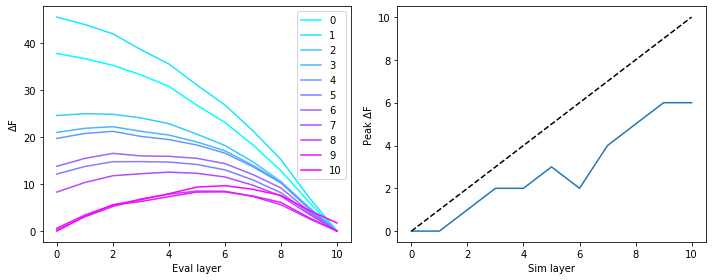

In [35]:
# Average free energy within small time window in center of the epoch
woi_t=np.mean(wois,axis=-1)
woi_idx=np.where((woi_t>=-20) & (woi_t<=20))[0]
m_all_layerF=np.mean(all_layerF[:,:,woi_idx],axis=2)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the mean free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF=m_all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerF=m_all_layerF[l,:]
    layerF=layerF-np.min(layerF)
    pk=np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [39]:
# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)